<a href="https://colab.research.google.com/github/MehraeenTimas/HateSpeechDetection/blob/main/HateSpeechDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech & Offensive Language Detection  

This notebook is a text classification using real-life database
We will compare **three models**:
- Random Forest (with TF-IDF)
- XGBoost
- Neural Network (Deep Learning with Embedding)

Dataset: [Hate Speech and Offensive Language Dataset](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset)

---

## Step 1: Install & Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Step 2: Load and Explore the Dataset
The dataset has three classes:
- `0` → Hate Speech
- `1` → Offensive Language
- `2` → Neither

In [2]:
df = pd.read_csv('labeled_data.csv',
                 engine='python',
                 on_bad_lines='skip',
                 quoting=3)

print(df.head())
print(f"Loaded {len(df)} rows.")

df = df[['tweet', 'class']].dropna()
print(f"After dropna: {len(df)} rows")

  Unnamed: 0 count hate_speech offensive_language  neither  class  \
0          0     3           0                  0      3.0    2.0   
1          1     3           0                  3      0.0    1.0   
2          2     3           0                  3      0.0    1.0   
3          3     3           0                  2      1.0    1.0   
4          4     6           0                  6      0.0    1.0   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Loaded 22117 rows.
After dropna: 20499 rows


## Step 3: Text Preprocessing
We clean the tweets by:
- Converting to lowercase
- Removing URLs, mentions, hashtags
- Removing punctuation and numbers
- Removing stopwords
- Lemmatizing words

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_tweet'] = df['tweet'].apply(preprocess_text)


df = df[df['clean_tweet'].str.strip() != '']
print(f"After cleaning: {len(df)} rows")
print(df[['tweet', 'clean_tweet']].head())

After cleaning: 20388 rows
                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                         clean_tweet  
0  rt woman shouldnt complain cleaning house amp ...  
1  rt boy dat coldtyga dwn bad cuffin dat hoe st ...  
2  rt dawg rt ever fuck bitch start cry confused ...  
3                                rt look like tranny  
4  rt shit hear might true might faker bitch told ya  


## Step 4: Prepare Features and Labels

In [4]:
X = df['clean_tweet']
y = df['class'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("Class distribution in train:\n", y_train.value_counts(normalize=True))

Train size: 16310, Test size: 4078
Class distribution in train:
 class
1    0.782710
2    0.159289
0    0.058001
Name: proportion, dtype: float64


## Model 1: Random Forest with TF-IDF Vectorization


In [5]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Shape: {X_train_vec.shape}")


Vocabulary size: 10000
Shape: (16310, 10000)


In [6]:
rf_model = RandomForestClassifier(
      n_estimators=300,
    max_depth=20,

    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

print("Training Random Forest... (this takes ~30–60 seconds)")
rf_model.fit(X_train_vec, y_train)
print("Training complete!")

Training Random Forest... (this takes ~30–60 seconds)
Training complete!


In [7]:
y_pred = rf_model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nFINAL TEST ACCURACY: {accuracy:.4f}")

class_names = ['Hate Speech', 'Offensive Language', 'Neither']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


FINAL TEST ACCURACY: 0.8458

Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.37      0.49      0.42       237
Offensive Language       0.97      0.85      0.90      3192
           Neither       0.65      0.96      0.78       649

          accuracy                           0.85      4078
         macro avg       0.66      0.77      0.70      4078
      weighted avg       0.88      0.85      0.86      4078



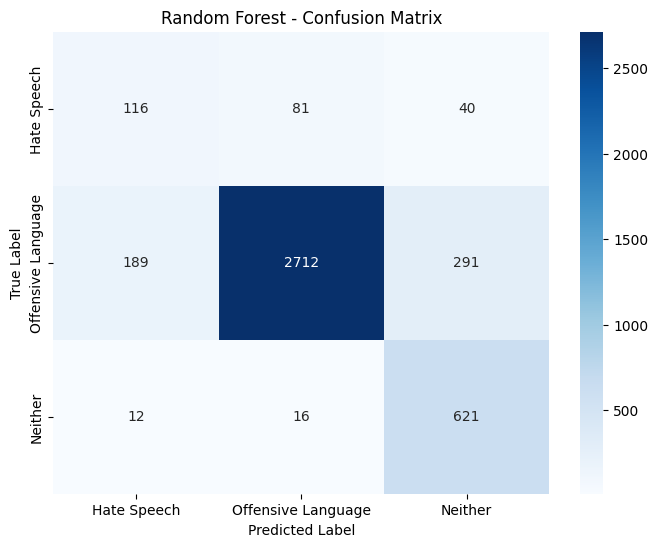

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Top 20 Most Predictive Words/Phrases (Random Forest)

In [9]:
importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

In [10]:
top_idx = np.argsort(importances)[::-1][:20]
print("\nTop 20 Most Important Words/Phrases:")
for i, idx in enumerate(top_idx):
    print(f"{i+1:2}. {feature_names[idx]:20} → {importances[idx]:.4f}")


Top 20 Most Important Words/Phrases:
 1. bitch                → 0.0966
 2. faggot               → 0.0597
 3. bird                 → 0.0346
 4. hoe                  → 0.0331
 5. nigger               → 0.0328
 6. trash                → 0.0328
 7. pussy                → 0.0300
 8. yankee               → 0.0223
 9. nigga                → 0.0209
10. fag                  → 0.0199
11. charlie              → 0.0173
12. white                → 0.0161
13. yellow               → 0.0158
14. fuck                 → 0.0138
15. white trash          → 0.0133
16. fucking              → 0.0130
17. as                   → 0.0127
18. shit                 → 0.0101
19. brownie              → 0.0096
20. aint                 → 0.0094


## Model 2: XGBoost Classifier
Often achieves higher accuracy than Random Forest.

In [11]:
label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)


y_test_encoded_map = y_test.apply(lambda x: label_encoder_train.transform([x])[0] if x in label_encoder_train.classes_ else -1)


valid_test_indices = y_test_encoded_map != -1
X_test_vec_filtered = X_test_vec[valid_test_indices.values]
y_test_encoded = y_test_encoded_map[valid_test_indices].values

print("Text data vectorized.")
print(f"Labels encoded. (y_train is 0-indexed, y_test filtered from {len(y_test)} to {len(y_test_encoded)} samples for evaluation of seen classes).")

print(f"DEBUG: Unique values in y_train_encoded: {np.unique(y_train_encoded)}")
print(f"DEBUG: Max value in y_train_encoded: {np.max(y_train_encoded)}")
print(f"DEBUG: Number of classes from label_encoder_train: {len(label_encoder_train.classes_)}")


xgbmodel = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    num_class=len(label_encoder_train.classes_)
)


xgbmodel.fit(X_train_vec, y_train)

Text data vectorized.
Labels encoded. (y_train is 0-indexed, y_test filtered from 4078 to 4078 samples for evaluation of seen classes).
DEBUG: Unique values in y_train_encoded: [0 1 2]
DEBUG: Max value in y_train_encoded: 2
DEBUG: Number of classes from label_encoder_train: 3


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [12]:
print(f"Train size: {len(X_train)}")
print(f"Test size:  {len(X_test)}")
print(f"Class distribution in train:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test:\n{y_test.value_counts(normalize=True)}")

Train size: 16310
Test size:  4078
Class distribution in train:
class
1    0.782710
2    0.159289
0    0.058001
Name: proportion, dtype: float64
Class distribution in test:
class
1    0.782737
2    0.159147
0    0.058117
Name: proportion, dtype: float64


In [13]:
y_pred = xgbmodel.predict(X_test_vec)

In [14]:
if 'Classifier' in str(type(xgbmodel)):
    score = accuracy_score(y_test_encoded, y_pred)
    print(f"Accuracy: {score:.4f}")
else:
    score = mean_squared_error(y_test_encoded, y_pred)
    print(f"MSE: {score:.4f}")

Accuracy: 0.8845


## Model 3: Neural Network (Deep Learning)
Uses word embeddings → captures semantic meaning.

In [15]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post', truncating='post')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=100, padding='post', truncating='post')

In [16]:
nnmodel = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

nnmodel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

nnmodel.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
nnmodel.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7787 - loss: 0.6836 - val_accuracy: 0.7811 - val_loss: 0.6383
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7900 - loss: 0.6158 - val_accuracy: 0.7971 - val_loss: 0.5168
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8220 - loss: 0.4525 - val_accuracy: 0.8571 - val_loss: 0.3806
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8679 - loss: 0.3669 - val_accuracy: 0.8486 - val_loss: 0.3950
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8837 - loss: 0.3380 - val_accuracy: 0.8326 - val_loss: 0.4226
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8965 - loss: 0.3082 - val_accuracy: 0.8719 - val_loss: 0.3556
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8960 - loss: 0.3009 - val_accuracy: 0.8792 - val_loss: 0.3320
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9035 - loss: 0.2694 - val_accuracy: 0.

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

FINAL TEST ACCURACY: 0.8931

Classification Report:
                    precision    recall  f1-score   support

       hate speech       0.71      0.02      0.04       237
offensive language       0.92      0.96      0.94      3192
           neither       0.79      0.87      0.83       649

          accuracy                           0.89      4078
         macro avg       0.81      0.62      0.60      4078
      weighted avg       0.88      0.89      0.87      4078



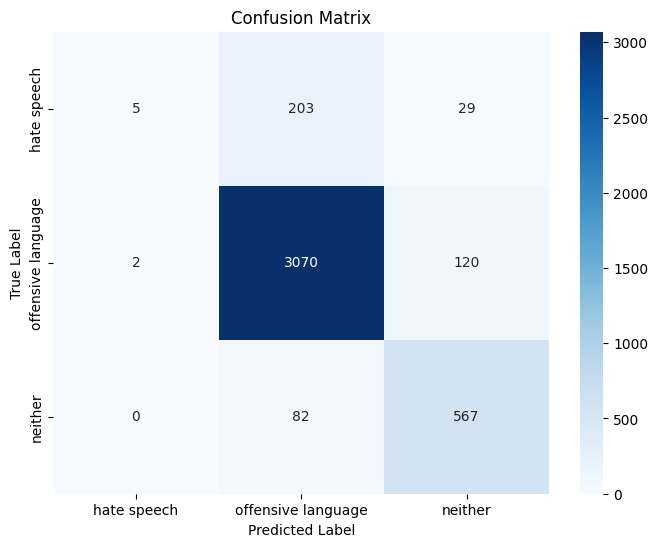

In [18]:
y_pred_prob = nnmodel.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"\nFINAL TEST ACCURACY: {acc:.4f}")


class_names = ['hate speech', 'offensive language', 'neither']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Final Model Comparison

In [22]:
print("FINAL MODEL COMPARISON")
print("="*50)
print(f"Random Forest     : {accuracy:.4f}")
print(f"XGBoost           : {score:.4f}")
print(f"Neural Network    : {acc:.4f}")
print("="*50)
best = max(accuracy, score, acc)
print(f"Best performing model: {['Random Forest', 'XGBoost', 'Neural Network'][ [accuracy, score, acc].index(best) ]} → {best:.4f}")

FINAL MODEL COMPARISON
Random Forest     : 0.8458
XGBoost           : 0.8845
Neural Network    : 0.8931
Best performing model: Neural Network → 0.8931


## Live Demo with Gradio
write down a comment

In [23]:
!pip install gradio --quiet

import gradio as gr
import numpy as np

In [24]:
def predict(text, algo):


    X_vec = vectorizer.transform([text])


    seq = tokenizer.texts_to_sequences([text])
    seq_pad = pad_sequences(seq, maxlen=100, padding='post', truncating='post')


    if algo == "Random Forest":
        pred = rf_model.predict(X_vec)[0]
        return class_names[int(pred)]

    elif algo == "XGBoost":
        pred = xgbmodel.predict(X_vec)[0]
        return class_names[int(pred)]

    elif algo == "Neural Network":
        probs = nnmodel.predict(seq_pad)
        pred = int(np.argmax(probs, axis=1)[0])
        return class_names[pred]

    else:
        return "Invalid model"


In [ ]:
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Textbox(label="Write a comment", lines=3, placeholder="Type any text..."),
        gr.Radio(
            ["Random Forest", "XGBoost", "Neural Network"],
            label="Choose algorithm"
        )
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="Hate Speech Detection",
    description="Classifies text as: hate speech | offensive | neither"
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6a9a93cf46a8c9ad6d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
